## **#08: Deep Learning: Unstructured Data (CNN and RNN)**
- Instructor: [Jaeung Sim](https://jaeungs.github.io/) (University of Connecticut)
- Course: OPIM 5512 Data Science Using Python
- Last updated: March 26, 2025

**Objectives**
1. Train and test an image classification model using convolutional neural networks (CNNs).
1. Build a natural language processing (NLP) model with recurrent neural networks (RNNs) to classify texts.

**References**
* [Deep Learning Basics by Google Colab](https://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb)
* [MNIST handwritten digit database](https://www.tensorflow.org/datasets/catalog/mnist)
* [Text classification with an RNN by TensorFlow](https://www.tensorflow.org/text/tutorials/text_classification_rnn)
* [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)
* [Masking and padding with Keras by TensorFlow](https://www.tensorflow.org/guide/keras/masking_and_padding)

#### **Part 1. Classification of MNIST Handwritten Digit with CNNs**

In this practice, you will build a convolutional neural network (CNN) classifier to classify images of handwritten digits in the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist) with a twist where we test our classifier on high-resolution hand-written digits from outside the dataset.

##### **1.1. Setup**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import pandas as pd
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.18.0


In [2]:
# Set common constants
this_repo_url = 'https://github.com/lexfridman/mit-deep-learning/raw/master/'
this_tutorial_url = this_repo_url + 'tutorial_deep_learning_basics'

The MNIST dataset containss 70,000 grayscale images of handwritten digits at a resolution of 28 by 28 pixels. The task is to take one of these images as input and predict the most likely digit contained in the image (along with a relative confidence in this prediction):

<img src="https://i.imgur.com/ITrm9x4.png" width="500px">

Now, we load the dataset. The images are 28 x 28 NumPy arrays, with pixel values ranging between 0 and 255. The *labels* are an array of integers, ranging from 0 to 9.

In [3]:
# Load the dataset with 60,000 train and 10,000 test images
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) # Number of images, 1D array of size (28 x 28), Number of channels
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [4]:
# Divide the pixel values by 255
def preprocess_images(imgs):
    # Should work for both a single image and an array of multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    # Check that the input images have the expected shape:
    # 1) 28x28 pixel images with one color channel (grayscale)
    # 2) 28x28 pixel images with multiple color channels
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape
    # Normalize the pixel values of the input images by dividing them by 255.0
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

Display the first 5 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

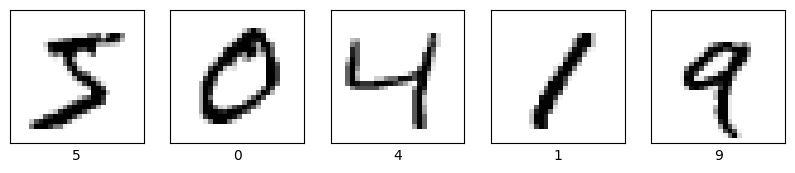

In [5]:
# Display first 5 images from the training set
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

##### **1.2. Building and Training the Model**

Building the neural network requires configuring the layers of the model, then compiling the model. In many cases, this can be reduced to simply stacking together layers.

The following code designs a CNN architecture as follows:
1. The input layer takes images of size 28 x 28 x 1 (one channel for grayscale) as input.
1. The first layer applies 32 convolution filters of size 3 x 3 with ReLU activation.
1. The second layer applies 64 convolution filters of size 3 x 3 with ReLU activation.
1. A max pooling layer is used to downsample the image, reducing its dimensions.
1. A dropout layer randomly turns off 25% of the neurons to reduce overfitting and improve convergence.
1. The output from the convolutional layers is flattened into a 1D array.
1. A fully connected layer with 128 neurons and ReLU activation is used to obtain all relevant data.
1. Another dropout layer is applied to further reduce overfitting.
1. The output layer consists of 10 neurons, each representing a class, with a softmax activation function to squash the matrix into output probabilities.

In [6]:
model = keras.Sequential()
# 32 convolution filters used each of size 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 64 convolution filters used each of size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
# Choose the best features via max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
# Flatten since too many dimensions, we only want a classification output
model.add(Flatten())
# Fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
# One more dropout
model.add(Dropout(0.5))
# Output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps. "accuracy" is the fraction of images that are correctly classified.

In [7]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_images` array. We verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [8]:
# Train the model
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 182s 96ms/step - accuracy: 0.8899 - loss: 0.3464
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 201s 96ms/step - accuracy: 0.9737 - loss: 0.0833
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 201s 95ms/step - accuracy: 0.9821 - loss: 0.0597
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 205s 97ms/step - accuracy: 0.9856 - loss: 0.0469
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 197s 94ms/step - accuracy: 0.9881 - loss: 0.0379


In [9]:
# Evaluate the model
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

(10000, 28, 28, 1)
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9887 - loss: 0.0345
Test accuracy: 0.9908999800682068


##### **1.3. (Optional) Real-time Prediction Demonstration**

With the model trained, we can use it to make predictions about some images. Let's step outside the MNIST dataset for that and go with the beautiful high-resolution images generated by a mixture of CPPN, GAN, VAE. See [great blog post by hardmaru](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) for the source data and a description of how these morphed animations are generated:

![MNIST dream](https://i.imgur.com/OrUJs9V.gif)

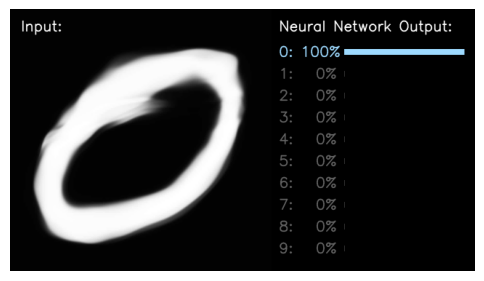

In [16]:
mnist_dream_path = 'images/mnist_dream.mp4'
mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

# Download the video if running in Colab
if not os.path.isfile(mnist_dream_path):
    print('downloading the sample video...')
    vid_url = this_tutorial_url + '/' + mnist_dream_path

    mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]

def smooth_imshow(img_disp):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
    plt.show()

cap = cv2.VideoCapture(mnist_dream_path)
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

# Go through all the frames and run our classifier on the high res MNIST images as they morph from number to number
while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break

    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))

    # Preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = preprocess_images(img_proc)
    img_proc = 1 - img_proc # Inverse since training dataset is white text with black background

    net_in = np.expand_dims(img_proc, axis=0) # Expand dimension to specify batch size of 1
    net_in = np.expand_dims(net_in, axis=3) # Expand dimension to specify number of channels

    preds = model.predict(net_in)[0]
    guess = np.argmax(preds)
    perc = np.rint(preds * 100).astype(int)

    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))

    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)

    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)

    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)

    y = 130
    for i, p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)

        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)

        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{}: {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60

    # If you don't want to save the output as a video, set this to False
    save_video = True

    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)

    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    IPython.display.clear_output(wait=True)
    smooth_imshow(img_disp)

cap.release()
if vw is not None:
    vw.release()

The above shows the prediction of the network by choosing the neuron with the highest output. While the output layer values add 1 to one, these do not reflect well-calibrated measures of "uncertainty". Often, the network is overly confident about the top choice that does not reflect a learned measure of probability. If everything ran correctly you should get an animation like this:

![MNIST dream predictions](https://i.imgur.com/eMF9FOG.gif)

#### **Part 2. Text Classification of IMDb Movie Reviews with RNNs**

In this practice, you will train a RNN model on the [IMDb large movie review dataset](https://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

This dataset is constructed for binary sentiment classification and provides a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided.

##### **2.1. Setup**

In [17]:
# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [18]:
# Create a helper function to plot graphs using `matplotlib`
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

The IMDb large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment. Let's download the dataset using `tfds`.

In [19]:
# Load the dataset
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [20]:
# Return a dataset of (text, label) pairs
for example, label in train_dataset.take(1):
  print('Text: ', example.numpy())
  print('Label: ', label.numpy())

Text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs.

**FYI: Buffer Size vs. Batch Size**
* The **buffer size** refers to the number of elements from the dataset that the data loader should prefetch in memory in order to speed up data loading. This is typically used when the dataset is too large to fit entirely in memory and needs to be loaded from disk or a remote location. A larger buffer size can lead to faster data loading, but can also consume more memory.
* The **batch size**, on the other hand, refers to the number of samples that are processed by the model at once during each training iteration. In other words, the batch size determines how many samples are used to calculate the gradients that update the model's parameters. A larger batch size can lead to faster training, but can also require more memory and result in less accurate gradients due to increased noise.

In [21]:
# Set the buffer and batch sizes
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Apply buffer and batch sizes to datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
# Print some examples from the shuffled dataset
for example, label in train_dataset.take(1):
  print('Texts: ', example.numpy()[:3])
  print()
  print('Labels: ', label.numpy()[:3])

Texts:  [b"In the Hollywood west those trail hands were a rough bunch who when they came to town, partied pretty hardy. After all trail driving was a lonely business back in the day before railroads got to all parts of the USA. <br /><br />The drovers who worked for trail boss Gil Favor as played by Eric Fleming were no different. But Fleming was a man of all business, he had a job to do and hired a top crew to do it. <br /><br />With the long run of Rawhide and the fact that the regulars stayed with it for the most part, we got to know all the drovers at some point. A some point story lines were focused around all of them, though the bulk were with Fleming and Clint Eastwood's character Rowdy Yates, the number 2 guy with the herd.<br /><br />Clint Eastwood's western image was molded by Rawhide, it's a shame that these are not shown more often. Probably because they were done in black and white. Had this been an NBC show, this would have been done in color like Bonanza and be running a

##### **2.2. Building and Training the Model**

**A. Create the text encoder**

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this practice sticks to the default behavior.

The following code creates a text encoder using the `TextVectorization` layer in TensorFlow as follows:

1. The `max_tokens` parameter sets the maximum size of the vocabulary to be used by the encoder. In this case, it is set to 1000.

1. The `adapt` method is called on the encoder object to build the vocabulary based on the training dataset. The `map` function is used to extract only the text data from the dataset, which is then passed to the `adapt` method. This allows the encoder to learn the vocabulary from the text data and create a mapping between words and integer indices.

1. After the vocabulary has been built, the encoder can be used to transform the text data into a sequence of integer indices that can be fed into a neural network.

In [23]:
# Create a text encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [24]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [25]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  8,   2, 355, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0],
       [142, 166,   6, ...,   0,   0,   0]])

In [26]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"In the Hollywood west those trail hands were a rough bunch who when they came to town, partied pretty hardy. After all trail driving was a lonely business back in the day before railroads got to all parts of the USA. <br /><br />The drovers who worked for trail boss Gil Favor as played by Eric Fleming were no different. But Fleming was a man of all business, he had a job to do and hired a top crew to do it. <br /><br />With the long run of Rawhide and the fact that the regulars stayed with it for the most part, we got to know all the drovers at some point. A some point story lines were focused around all of them, though the bulk were with Fleming and Clint Eastwood's character Rowdy Yates, the number 2 guy with the herd.<br /><br />Clint Eastwood's western image was molded by Rawhide, it's a shame that these are not shown more often. Probably because they were done in black and white. Had this been an NBC show, this would have been done in color like Bonanza and be running

**B. Create the model**

![image](https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.

The code to implement this is below:

In [29]:
# Build the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

**FYI: Masking and Padding**
* **Masking** is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.
* **Padding** is a special form of masking where the masked steps are at the start or the end of a sequence. Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences.

**Example of Padding Sequence Data with Tokenized Texts**

```
[
  ["Hello", "world", "!"],
  ["How", "are", "you", "doing", "today"],
  ["The", "weather", "will", "be", "nice", "tomorrow"],
]
```

After vocabulary lookup, the data might be vectorized as integers like:

```
[
  [71, 1331, 4231]
  [73, 8, 3215, 55, 927],
  [83, 91, 1, 645, 1253, 927],
]
```

The data is a nested list where individual samples have length 3, 5, and 6, respectively. Since the input data for a deep learning model must be a single tensor (of shape e.g., `(batch_size, 6, vocab_size)` in this case), samples that are shorter than the longest item need to be padded with some placeholder value (alternatively, one might also truncate long samples before padding short samples).

Keras provides a utility function to truncate and pad Python lists to a common length: `tf.keras.preprocessing.sequence.pad_sequences`. By using this function, you may convert raw vectors into the following padded outcomes:

```
[[ 711  632   71    0    0    0]
 [  73    8 3215   55  927    0]
 [  83   91    1  645 1253  927]]
```

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the embedding support masking.

In [30]:
# Check if each layer supports masking
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**C. Train the model**

In [32]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [33]:
# Train the RNN model
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.5187 - loss: 0.6794 - val_accuracy: 0.8188 - val_loss: 0.4514
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.7958 - loss: 0.4363 - val_accuracy: 0.8385 - val_loss: 0.3764
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.8395 - loss: 0.3631 - val_accuracy: 0.8557 - val_loss: 0.3454


In [34]:
# Assess the model statistics
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.8573 - loss: 0.3384
Test Loss: 0.3361680805683136
Test Accuracy: 0.856719970703125


(0.0, 0.8692456215620041)

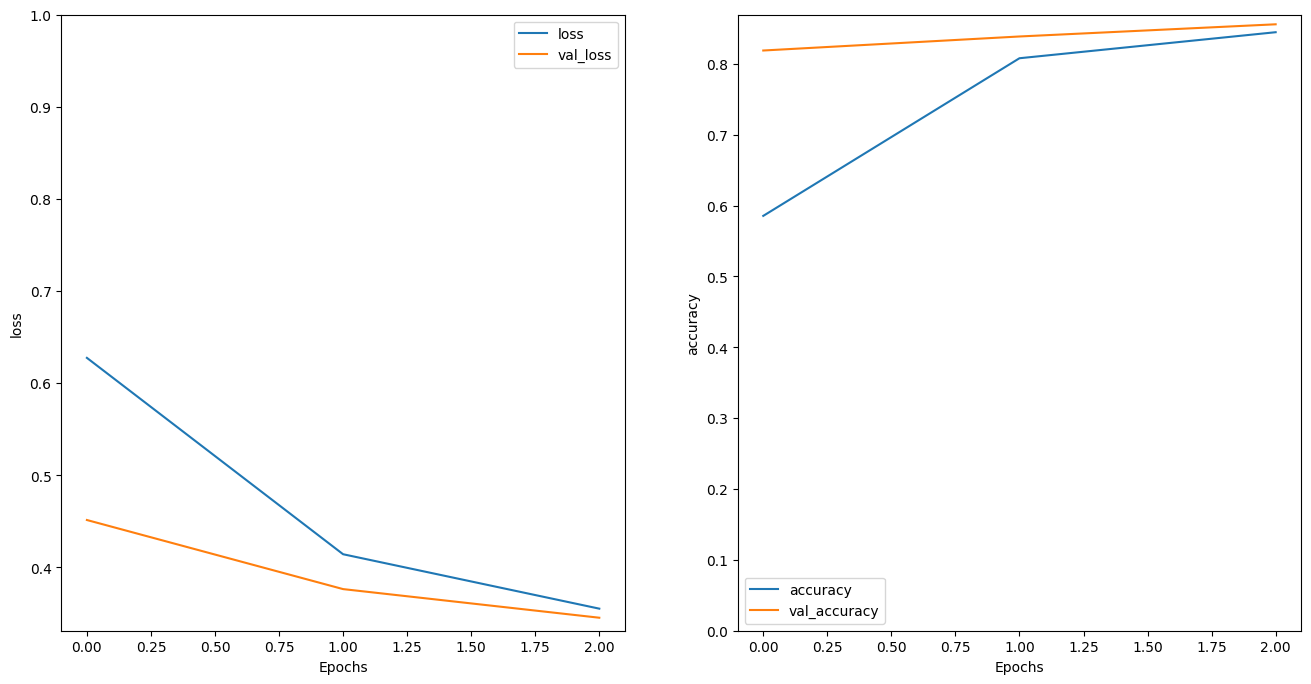

In [35]:
# Visualize the history of loss and accuracy by epoch
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'loss')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'accuracy')
plt.ylim(0, None)

**D. Build and train the model by staking two or more LSTM layers**

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (`batch_size, output_features`)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![image](https://www.tensorflow.org/static/text/tutorials/images/layered_bidirectional.png)

The interesting thing about using an RNN with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [37]:
# Define the RNN architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [38]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [39]:
# Train the model
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 1479s 4s/step - accuracy: 0.5176 - loss: 0.6830 - val_accuracy: 0.8010 - val_loss: 0.4444
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 1492s 4s/step - accuracy: 0.8133 - loss: 0.4203 - val_accuracy: 0.8453 - val_loss: 0.3638
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 1462s 4s/step - accuracy: 0.8539 - loss: 0.3464 - val_accuracy: 0.8458 - val_loss: 0.3345


In [40]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 295s 754ms/step - accuracy: 0.8542 - loss: 0.3243
Test Loss: 0.32103145122528076
Test Accuracy: 0.8560799956321716


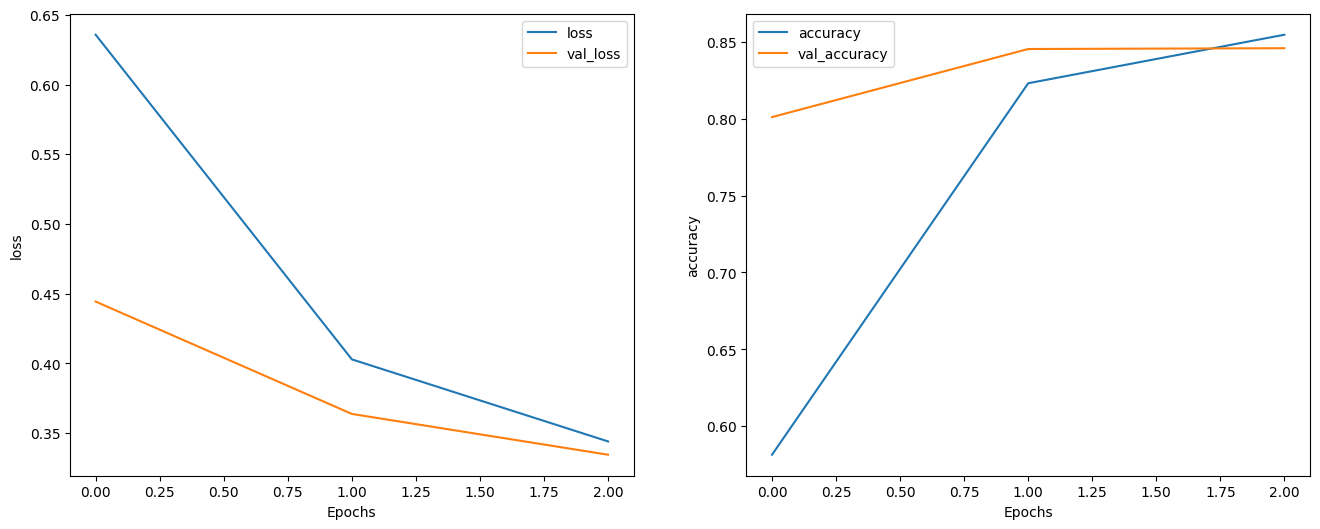

In [41]:
# Visualize the results
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'loss')
plt.subplot(1, 2, 2)
plot_graphs(history, 'accuracy')